In [1]:
from scipy.io import loadmat
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mat = np.squeeze(loadmat('./image/BSR_bsds500/BSR/BSDS500/data/groundTruth/train/41004.mat')['groundTruth'])
img = imread('./image/BSR_bsds500/BSR/BSDS500/data/images/train/41004.jpg')
segs = []
cts = []
for i in range(mat.shape[0]):
    segs.append(mat[i][0][0][0])
    cts.append(mat[i][0][0][1])

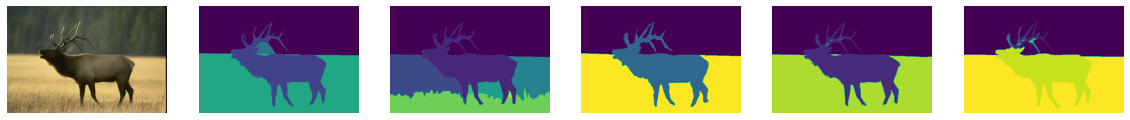

In [4]:
fig, axes = plt.subplots(1, 6, figsize=(20, 60))
axes[0].imshow(img)
axes[0].axis('off')
for ax, seg in zip(axes[1:], segs):
    ax.imshow(seg)
    ax.axis('off')

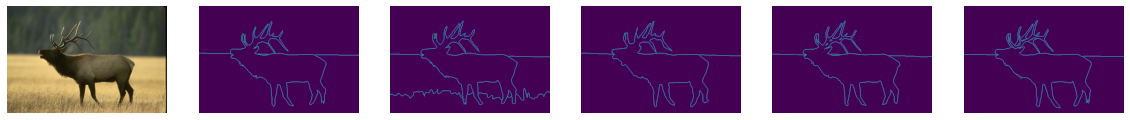

In [5]:
fig, axes = plt.subplots(1, 6, figsize=(20, 60))
axes[0].imshow(img)
axes[0].axis('off')
for ax, ct in zip(axes[1:], cts):
    ax.imshow(ct)
    ax.axis('off')

(80, 120)


(-0.5, 119.5, 79.5, -0.5)

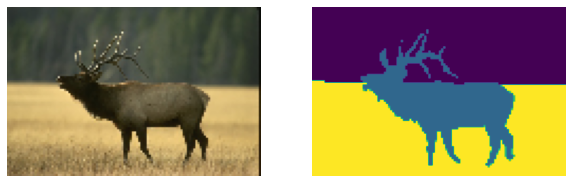

In [6]:
import cv2 as cv
h, w, _ = img.shape
s = 4
sm_img = cv.resize(img, (w//s, h//s))
sm_seg = cv.resize(segs[2], (w//s, h//s))
print(sm_seg.shape)
fig, axes = plt.subplots(1, 2, figsize=(10, 30))
axes[0].imshow(sm_img)
axes[1].imshow(sm_seg)
axes[0].axis('off')
axes[1].axis('off')

In [7]:
h, w, _ = sm_img.shape
data = sm_img.reshape(-1, 3) / 255
x = np.repeat(np.arange(w)[np.newaxis, :], h, axis=0).reshape(-1, 1) / w
y = np.repeat(np.arange(h)[:, np.newaxis], w, axis=1).reshape(-1, 1) / h
data = np.concatenate([data, x, y], axis=1)
label = sm_seg.reshape(-1)

4


<BarContainer object of 4 artists>

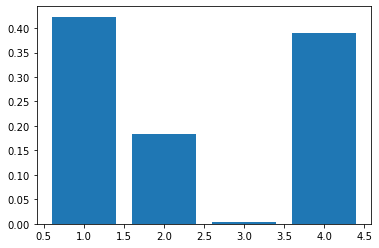

In [8]:
occur = []
print(label.max())
for l in np.unique(label):
    occur.append(np.count_nonzero(label == l))
fig, ax = plt.subplots()
ax.bar(np.unique(label), np.array(occur)/label.shape[0])

In [9]:
def index2d(h, w, ind):
    return ind // w, ind % w

(-0.5, 119.5, 79.5, -0.5)

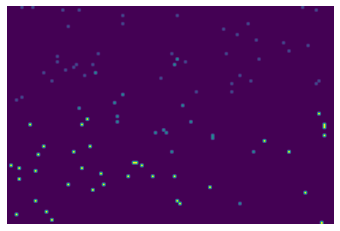

In [10]:
from sklearn.model_selection import StratifiedKFold
batches = 100
skf = StratifiedKFold(batches, shuffle=True)

batch_img = np.zeros((h, w))
for i in list(skf.split(data, label))[2][1]:
    r, c = index2d(h, w, i)
    v = label[i]
    batch_img[r, c] = v
plt.imshow(batch_img)
plt.gca().axis('off')

In [11]:
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
#import ipdb
def circular_moments(phases, masks, split=False, burn_in_prop=.5):
    """
    phases: shape [steps, ...]
    masks(one hot indicator): shape [num_groups, ...]
    split: if return synch and desynch separately
    burn_in_prop: proportion of steps to be considered, steps before will not be added into loss
    """
    num_groups = masks.shape[0]
    group_size = masks.sum(1)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]
    
    burn_in_steps = int(burn_in_prop * T) - 1
    masked_phases = phases.unsqueeze(1) * masks # [steps, num_groups, ...]
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
    synch = 1 - go.sum(-1)/num_groups

    mean_angles = torch.atan2(yy.sum(-1),xx.sum(-1))
    desynch = 0
    for m in np.arange(1, int(np.floor(num_groups/2.))+1):
#         K_m = 1 if m < int(np.floor(num_groups/2.)) + 1 else -1
        desynch += (1.0 / (2* num_groups * m**2)) * (torch.cos(m*mean_angles).sum(-1)**2 + torch.sin(m*mean_angles).sum(-1)**2)
        
    loss = (synch + desynch)
    
    if split == True:
        return loss[burn_in_steps:,...].mean(), synch[burn_in_steps:,...].mean(), desynch[burn_in_steps:,...].mean()
    else:
        return loss[burn_in_steps:,...].mean()

In [13]:
class coupling_net_minju(torch.nn.Module):
    def __init__(self, feature_dim, num_hid_units=256):
        """
        Take in a set of embeddings of nodes and produce link weights. Weights will be produced separately, only the embeddings of two correponding nodes will be considered. Like relational networks.
        input: shape [batch_size, feature_dim]
        coupling(normalized unsymmetric): shape [batch_size, batch_size]
        """
        super(coupling_net_minju, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2*feature_dim, num_hid_units),
            torch.nn.BatchNorm1d(num_hid_units),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hid_units, num_hid_units),
            torch.nn.BatchNorm1d(num_hid_units),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hid_units,1,bias=False)
        )
    def forward(self,x):
        batch_size = x.shape[0]
#         Bx2 --> (bXb)x4 --> (bxb)x1 --> bxb
        x = torch.cat([x[:,None].repeat(1,batch_size,1),x[None,:].repeat(batch_size,1,1)],dim=2)
        #Infer couplings 
        x = self.layers(x.view(-1, x.shape[-1])).squeeze().reshape(batch_size, batch_size)
        return torch.nn.functional.normalize(x, p=2, dim=1)

In [44]:
def run_kuramoto(coupling, omega=None, alpha=.1, steps=100, phase_init=None):
    """
    return: The phase evolution with size: [batch, steps, ...]
    """
    num_units = coupling.shape[1]
    if len(coupling.shape)<3:
        coupling = coupling.unsqueeze(0)
    #burn_in_steps = int(burn_in_prop * steps)
    
    if omega is None:
        omega = torch.zeros(1, num_units).to(device)

    if phase_init == None:
        phase = torch.normal(np.pi,0.1,(num_units,)).float().unsqueeze(0).to(device)
    else:
        phase = phase_init
    flow = []
    for i in range(steps):
        phase = kuramoto_step(phase,coupling,omega,alpha=alpha)
        flow.append(phase)
    flow = torch.stack(flow)
    return flow

def kuramoto_step(phase, coupling, omega, alpha=.01):
    phase_diffs = torch.sin(phase.unsqueeze(-1) - phase.unsqueeze(-2))
    #delta =\
        #torch.matmul(coupling,torch.sin(phase).unsqueeze(1)).squeeze(1) * torch.cos(phase)\
            #-torch.matmul(coupling,torch.cos(phase).unsqueeze(1)).squeeze(1) * torch.sin(phase)
    delta = alpha * (omega + (coupling * phase_diffs).sum(1))
    return phase + delta
    #return phase + alpha*(omega+delta)

In [15]:
def phase_evol_ax(ax, phases, masks=None, save_name=None):
    phases = np.squeeze(np.array(phases, dtype=np.float32))
    phases = (phases % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
    if masks is not None:
        group_num = masks.shape[0]
        annot_bool = [True] * group_num
        colors = {}
        for num in range(group_num):
            mean_angle = np.arctan2((np.sin(phases[-1]) * masks[0][num]).sum(),
                                    (np.cos(phases[-1]) * masks[0][num]).sum() + 1e-6)
            colors[num] = num*50#(mean_angle + 2 * np.pi) % (2 * np.pi) / (2 * np.pi)
        for i in range(phases.shape[1]):
            for num in range(group_num):
                if masks[num][i]:
                    ax.plot(phases[:, i], color=plt.cm.hsv(colors[num]), alpha=0.5)
                    if annot_bool[num]:
                        ax.text(phases.shape[0] + 0.01, phases[-1, i], 'group{}'.format(num+1),
                                 horizontalalignment='left', size='small', color=plt.cm.hsv(colors[num]))
                        annot_bool[num] = False
        ax.set_xlabel('Time')
        ax.set_ylabel('Phase')
        ax.set_title('Phase Evolution')
        ax.set_ylim([0,2*np.pi])
    else:
        for i in range(phases.shape[1]):
            ax.set_plot(phases[:, i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Phase')
        ax.set_title('Phase Evolution')

- skf will split the data evenly into batches
- During training, the dynamic will run in each batch and during test the dynamic will run in all test data
- train_prop defines how many groups to use for training, only sample data in order, from begining to last
- test_prop is the same as train_prop but will be the data for test

In [16]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
label_bin = lb.fit_transform(label)

train_prop = 0.5 # this means roughly 50% of pixels
test_prop = 0.7 # test with 70%
train_data = []
train_label = []
train_idx = []
test_data = []
test_label = []
test_idx = []
for i, (_, idx) in enumerate(skf.split(data, label)):
    if i < batches*train_prop:
        train_data.append(data[idx, :])
        train_label.append(label_bin[idx])
        train_idx.append(idx)
    if i < batches*test_prop:
        test_data.append(data[idx, :])
        test_label.append(label_bin[idx])
        test_idx.append(idx)
train_data = np.stack(train_data, axis=0)
train_label = np.stack(train_label, axis=0)
train_idx = np.stack(train_idx, axis=0)
test_data = np.concatenate(test_data, axis=0)
test_label = np.concatenate(test_label, axis=0)
test_idx = np.concatenate(test_idx, axis=0)

In [17]:
print(train_data.shape)
print(train_label.shape)
print(train_idx.shape)
print(test_data.shape)
print(test_label.shape)
print(test_idx.shape)

(50, 96, 5)
(50, 96, 4)
(50, 96)
(6720, 5)
(6720, 4)
(6720,)


In [18]:
train_data_ = torch.from_numpy(train_data).to(device).float()
train_label_ = torch.from_numpy(train_label).to(device).float()
test_data_ = torch.from_numpy(test_data).to(device).float()
test_label_ = torch.from_numpy(test_label).to(device).float()

In [21]:
from collections import deque
train_epochs = 50
train_lr = 1e-4
train_kura_steps = 50
train_kura_alpha = 0.1

net = coupling_net_minju(feature_dim=5, num_hid_units=256).to(device)
optim = torch.optim.Adam(net.parameters(), lr=train_lr)
#lr_lambda = lambda epoch : np.power(0.5, int(epoch/5))*0.1
#scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda)

loss_history = []
report_loss = deque(10)
for epoch in range(train_epochs):
    for d, l in zip(train_data_, train_label_):
        coupling = net(d)
        phase_flow=\
            run_kuramoto(coupling,alpha=train_kura_alpha,steps=train_kura_steps)
        loss = circular_moments(phase_flow, l.transpose(0, 1), burn_in_prop=1)
        loss_history.append(loss.item())
        report_loss.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()

    if epoch % int(train_epochs*0.1) == 0:
        print(f"Epoch {epoch} loss {np.mean(report_loss)}")

Epoch 0 loss 0.8013269305229187
Epoch 5 loss 0.4213295578956604
Epoch 10 loss 0.42585039138793945
Epoch 15 loss 0.8867892026901245
Epoch 20 loss 0.6769354939460754
Epoch 25 loss 0.549964964389801
Epoch 30 loss 0.42017707228660583
Epoch 35 loss 0.47885072231292725
Epoch 40 loss 0.4443705081939697
Epoch 45 loss 0.41137972474098206


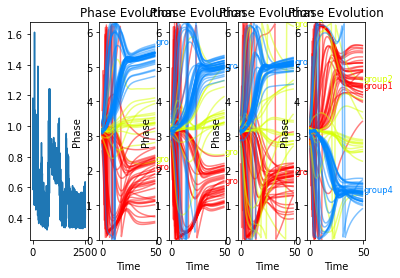

In [22]:
net.eval()
with torch.no_grad():
    sample_batch = np.random.choice(train_data.shape[0], 4)
    flows = []
    masks = []
    for batch in sample_batch:
        coupling = net(train_data_[batch])
        phase_flow=\
            run_kuramoto(coupling,alpha=train_kura_alpha,steps=train_kura_steps)
        flows.append(phase_flow.data.numpy())
        masks.append(train_label_[batch].transpose(0,1).data.numpy())

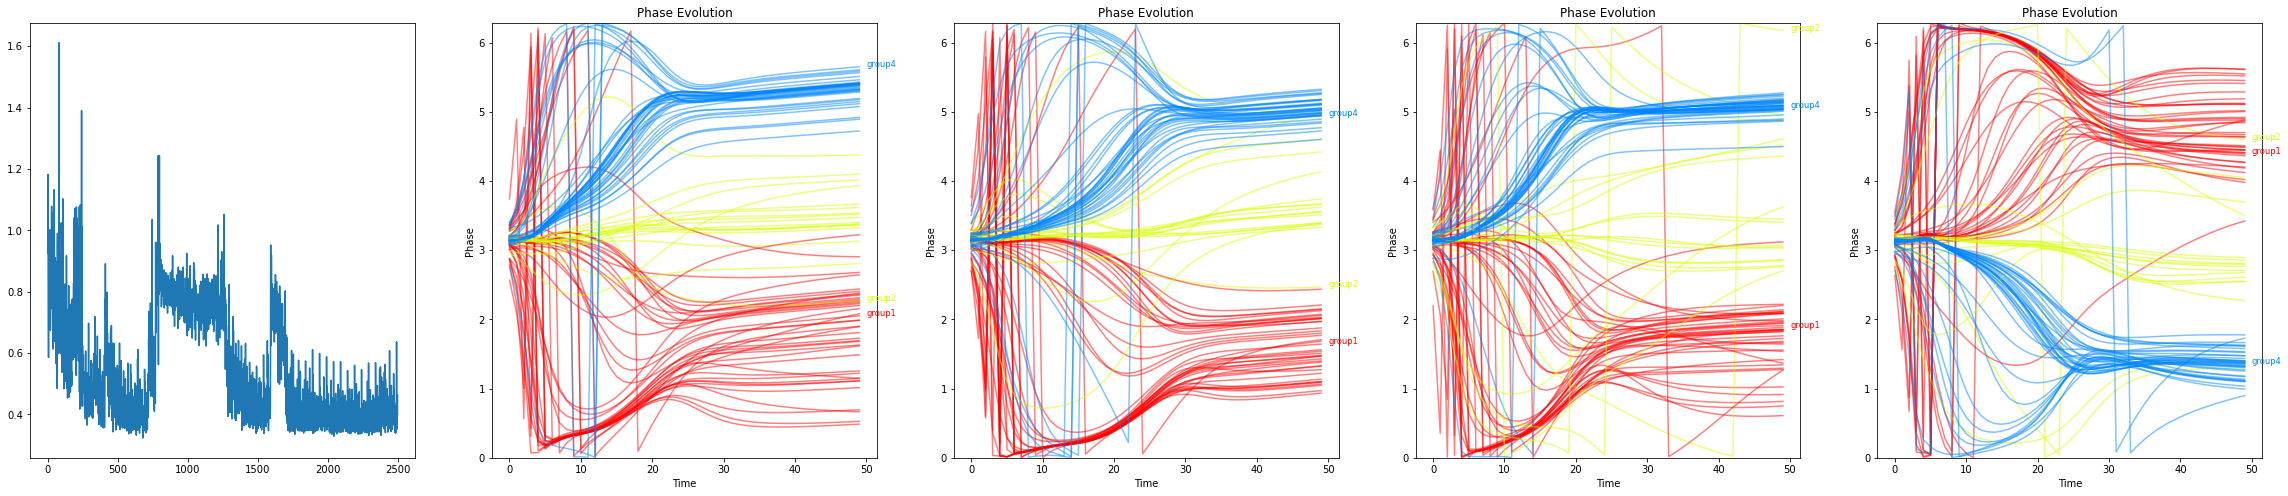

In [25]:
fig, axes = plt.subplots(1, 5, figsize=(40, 8))
axes[0].plot(loss_history)
for flow, mask, ax in zip(flows, masks, axes[1:]):
    phase_evol_ax(ax, flow, mask)

In [47]:
test_kura_steps = 50
test_kura_alpha = 0.05
with torch.no_grad():
    coupling = net(test_data_[5700:,])
    phase_flow=\
        run_kuramoto(coupling,alpha=test_kura_alpha,steps=test_kura_steps)

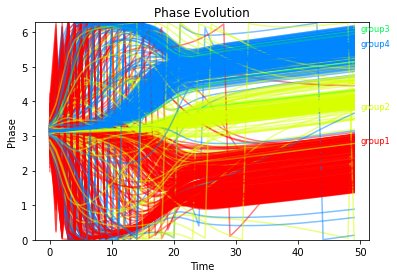

In [48]:
fig, ax = plt.subplots()
phase_evol_ax(ax, phase_flow.data.numpy(), test_label_[5700:].transpose(0,1).data.numpy())

In [50]:
last_phase = phase_flow[-1].data.numpy()
last_phase = np.squeeze((last_phase % ((2*np.pi) + 2*np.pi)) % (2*np.pi))
print(last_phase.shape)

(1020,)


In [53]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
km.fit(np.stack([np.sin(last_phase), np.cos(last_phase)], axis=1))
km_label = km.labels_+1

(-0.5, 119.5, 79.5, -0.5)

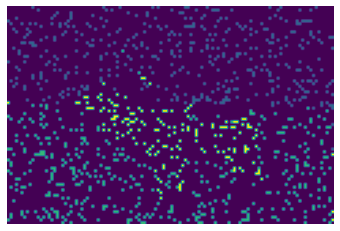

In [55]:
clustered_img = np.zeros((h, w))
for i in range(last_phase.shape[0]):
    r, c = index2d(h, w, test_idx[5700:][i])
    v = km_label[i]
    clustered_img[r, c] = v
plt.imshow(clustered_img)
plt.gca().axis('off')